In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from linearmodels.system import IV3SLS
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

It is key to use least squares in three stages: **IV3SLS**.


# 1. DATA SIMULATION
We simulate data to illustrate the model

In [2]:
np.random.seed(123)
n = 1000  # number of consumers

In [3]:
# Exogenous variables
household_income = np.random.normal(3000, 1000, n)
net_debt = np.random.normal(10000, 5000, n)

In [4]:
# Variables for changes in spending patterns
discretionary_expenses = -0.15 * household_income + 0.03 * net_debt + np.random.normal(0, 500, n)
basic_expenses = -0.05 * household_income + 0.01 * net_debt + np.random.normal(0, 200, n)
frec_offers = -0.0002 * household_income + 0.00003 * net_debt + np.random.normal(0, 1, n)

In [5]:
# Variables for job search
jobs_wanted = -0.001 * household_income + 0.0002 * net_debt + np.random.normal(0, 2, n)
lost_expectation = -0.0003 * household_income + 0.00004 * net_debt + np.random.normal(0, 0.5, n)
jobs_lower_status = -0.0002 * household_income + 0.00003 * net_debt + np.random.normal(0, 0.5, n)

In [6]:
# Variables for changes in consumption
change_brands = -0.0002 * household_income + 0.00005 * net_debt + np.random.normal(0, 0.5, n)
deferred_purchases = -0.0003 * household_income + 0.00006 * net_debt + np.random.normal(0, 0.7, n)
change_preferences = -0.0001 * household_income + 0.00003 * net_debt + np.random.normal(0, 0.4, n)

In [7]:
# Calculate the subscripts
changes_expense = 0.4 * discretionary_expenses + 0.3 * basic_expenses + 0.3 * frec_offers
job_search = 0.5 * jobs_wanted + 0.3 * lost_expectation + 0.2 * jobs_lower_status
changes_consumption = 0.4 * change_brands + 0.4 * deferred_purchases + 0.2 * change_preferences

### Frugal Fatigue Index

In [8]:
# Calculate the Frugal Fatigue Index
frugal_fatigue = 0.4 * changes_expense + 0.3 * job_search + 0.3 * changes_consumption + np.random.normal(0, 50, n)

In [9]:
# Dataframe
data = pd.DataFrame({
    # Control variables
    'household_income': household_income,
    'net_debt': net_debt,
    
    # Expenditure variables
    'discretionary_expenses': discretionary_expenses,
    'basic_expenses': basic_expenses,
    'frec_offers': frec_offers,
    
    # Employment variables
    'jobs_wanted': jobs_wanted,
    'lost_expectation': lost_expectation,
    'jobs_lower_status': jobs_lower_status,
    
    # Consumption variables
    'change_brands': change_brands,
    'deferred_purchases': deferred_purchases,
    'change_preferences': change_preferences,
    
    # Subscripts
    'changes_expense': changes_expense,
    'job_search': job_search,
    'changes_consumption': changes_consumption,
    
    # Main index
    'frugal_fatigue': frugal_fatigue
})

# 2. ESTIMATION OF THE MODELS

In [10]:
# Split data for training (70%) and testing (30%)
train, test = train_test_split(data, test_size=0.3, random_state=42)

In [11]:
# Model for changes in expenditure
X_spent = sm.add_constant(train[['discretionary_expenses', 'basic_expenses', 'frec_offers', 
                                'household_income', 'net_debt']])
spent_model = sm.OLS(train['changes_expense'], X_spent).fit()

In [12]:
# Job search model
X_job = sm.add_constant(train[['jobs_wanted', 'lost_expectation', 'jobs_lower_status', 
                                'household_income', 'net_debt']])
job_model = sm.OLS(train['job_search'], X_job).fit()

In [13]:
# Model for changes in consumption
X_consumption = sm.add_constant(train[['change_brands', 'deferred_purchases', 'change_preferences', 
                                  'household_income', 'net_debt']])
consumption_model = sm.OLS(train['changes_consumption'], X_consumption).fit()

In [14]:
# Main model of frugal fatigue
X_fatigue = sm.add_constant(train[['changes_expense', 'job_search', 'changes_consumption', 
                                 'household_income', 'net_debt']])
fatigue_model = sm.OLS(train['frugal_fatigue'], X_fatigue).fit()

# 3. EVALUATION AND PREDICTION

In [15]:
def evaluate_model(model, X, y):
    """Evaluate a model with basic metrics"""
    predictions = model.predict(X)
    mse = np.mean((predictions - y)**2)
    r2 = model.rsquared
    return {
        'MSE': mse,
        'R2': r2,
        'Parameters': model.params
    }

In [16]:
# Evaluate test set
X_spent_test = sm.add_constant(test[['discretionary_expenses', 'basic_expenses', 'frec_offers', 
                                    'household_income', 'net_debt']])
X_job_test = sm.add_constant(test[['jobs_wanted', 'lost_expectation', 'jobs_lower_status', 
                                    'household_income', 'net_debt']])
X_consumption_test = sm.add_constant(test[['change_brands', 'deferred_purchases', 'change_preferences', 
                                    'household_income', 'net_debt']])

In [17]:
# Subscript Predictions
pred_spent = spent_model.predict(X_spent_test)
pred_job = job_model.predict(X_job_test)
pred_consumption = consumption_model.predict(X_consumption_test)

In [18]:
# Creating a dataframe for frugal fatigue prediction
X_fatigue_test = sm.add_constant(pd.DataFrame({
    'changes_expense': pred_spent,
    'job_search': pred_job,
    'changes_consumption': pred_consumption,
    'household_income': test['household_income'].values,
    'net_debt': test['net_debt'].values
}))

In [19]:
# Predicting frugal fatigue
pred_fatigue = fatigue_model.predict(X_fatigue_test)

In [20]:
# Calculate the metrics
results_spent = evaluate_model(spent_model, X_spent_test, test['changes_expense'])
results_job = evaluate_model(job_model, X_job_test, test['job_search'])
results_consumption = evaluate_model(consumption_model, X_consumption_test, test['changes_consumption'])
results_fatigue = evaluate_model(fatigue_model, X_fatigue_test, test['frugal_fatigue'])

# 4. EARLY WARNING SYSTEM

In [21]:
def classify_fatigue(fatigue_value, high_threshold=150, mean_threshold=80):
    """Classify the level of financial fatigue"""
    if fatigue_value > high_threshold:
        return "HIGH"
    elif fatigue_value > mean_threshold:
        return "MEAN"
    else:
        return "LOW"

In [22]:
# Sort the predictions
fatigue_levels = [classify_fatigue(valor) for valor in pred_fatigue]
test_with_pred = test.copy()
test_with_pred['pred_fatigue'] = pred_fatigue
test_with_pred['fatigue_levels'] = fatigue_levels

In [23]:
# Function to apply on new data
def predict_frugal_fatigue(new_data, spent_model, job_model, consumption_model, fatigue_model):
    """Predicts the level of financial fatigue for new consumers.
       The 'new_data' parameter uses the DataFrame with all the necessary variables.
       And return the DataFrame with predictions and fatigue levels.
    """
    # Preparing data for submodels
    X_new_spent = sm.add_constant(new_data[['discretionary_expenses', 'basic_expenses', 'frec_offers', 
                                    'household_income', 'net_debt']])
    X_new_job = sm.add_constant(new_data[['jobs_wanted', 'lost_expectation', 'jobs_lower_status', 
                                    'household_income', 'net_debt']])
    X_new_consumption = sm.add_constant(new_data[['change_brands', 'deferred_purchases', 'change_preferences', 
                                    'household_income', 'net_debt']])
    
    # Subscript Predictions
    pred_spent = spent_model.predict(X_new_spent)
    pred_job = job_model.predict(X_new_job)
    pred_consumption = consumption_model.predict(X_new_consumption)
    
    # Prepare data for the main model
    X_new_fatigue = sm.add_constant(pd.DataFrame({
        'changes_expense': pred_spent,
        'job_search': pred_job,
        'changes_consumption': pred_consumption,
        'household_income': new_data['household_income'].values,
        'net_debt': new_data['net_debt'].values
    }))
    
    # Predicting Frugal Fatigue
    pred_fatigue = fatigue_model.predict(X_new_fatigue)
    
    # Create the results dataframe
    results = new_data.copy()
    results['pred_fatigue'] = pred_fatigue
    results['fatigue_levels'] = [classify_fatigue(valor) for valor in pred_fatigue]
    
    return results

# Use case with new simulated data
new_consumers = pd.DataFrame({
    'household_income': np.random.normal(3000, 1000, 5),
    'net_debt': np.random.normal(10000, 5000, 5),
    'discretionary_expenses': np.random.normal(-300, 500, 5),
    'basic_expenses': np.random.normal(-100, 200, 5),
    'frec_offers': np.random.normal(3, 1, 5),
    'jobs_wanted': np.random.normal(2, 2, 5),
    'lost_expectation': np.random.normal(0.5, 0.5, 5),
    'jobs_lower_status': np.random.normal(0.7, 0.5, 5),
    'change_brands': np.random.normal(0.6, 0.5, 5),
    'deferred_purchases': np.random.normal(0.8, 0.7, 5),
    'change_preferences': np.random.normal(0.5, 0.4, 5)
})

In [24]:
# Get predictions
new_predictions = predict_frugal_fatigue(new_consumers, 
                                                spent_model, 
                                                job_model, 
                                                consumption_model, 
                                                fatigue_model)

In [25]:
# Show results
print("Summary of the Frugal Fatigue Model")
print("\nMain model coefficients:")
print(fatigue_model.summary().tables[1])

print("\nPredictions for new consumers:")
print(new_predictions[['household_income', 'net_debt', 'pred_fatigue', 'fatigue_levels']])

Summary of the Frugal Fatigue Model

Main model coefficients:
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   5.1259      7.123      0.720      0.472      -8.859      19.111
changes_expense         0.3925      0.009     43.968      0.000       0.375       0.410
job_search              1.1368      1.828      0.622      0.534      -2.453       4.727
changes_consumption     6.9290      5.372      1.290      0.198      -3.618      17.476
household_income        0.0008      0.003      0.301      0.763      -0.004       0.006
net_debt               -0.0005      0.001     -0.877      0.381      -0.002       0.001

Predictions for new consumers:
   household_income      net_debt  pred_fatigue fatigue_levels
0       1636.148343   8593.787590    -72.108837            LOW
1       2405.237184   6361.701450    147.209468           MEAN
2       4143.

# 5. NONLINEAR COMPLEXITY AND INTERPRETABILITY
## 5.1. Transformaciones No Lineales con Diagnóstico Visual
### Implementación

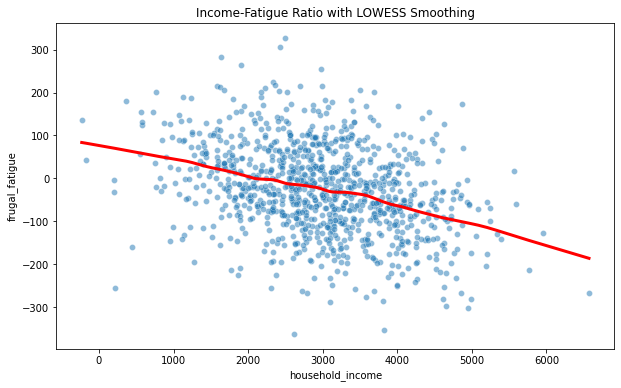

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.nonparametric.smoothers_lowess import lowess

# Example of a LOWESS chart for income and fatigue
plt.figure(figsize=(10, 6))
sns.scatterplot(x='household_income', y='frugal_fatigue', data=data, alpha=0.5)
lowess_line = lowess(data['frugal_fatigue'], data['household_income'], frac=0.3)
plt.plot(lowess_line[:, 0], lowess_line[:, 1], 'r-', linewidth=3)
plt.title('Income-Fatigue Ratio with LOWESS Smoothing')
plt.show()

## 5.2 Generalized Additive Models (GAM)
### Implementation with interpretation

In [27]:
# Define X and Y using the same variables as the original model
X_fatigue_train = sm.add_constant(train[['changes_expense', 'job_search', 'changes_consumption', 
                                      'household_income', 'net_debt']])
y_fatigue_train = train['frugal_fatigue']

X_fatigue_test = sm.add_constant(test[['changes_expense', 'job_search', 'changes_consumption', 
                                    'household_income', 'net_debt']])
y_fatigue_test = test['frugal_fatigue']

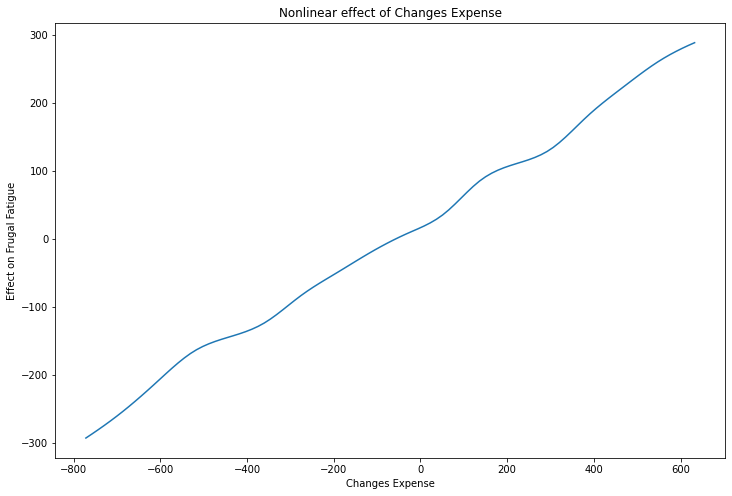

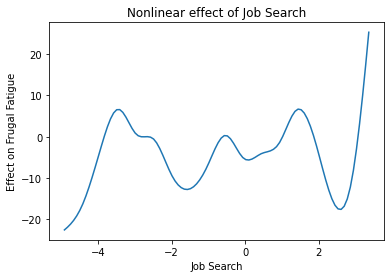

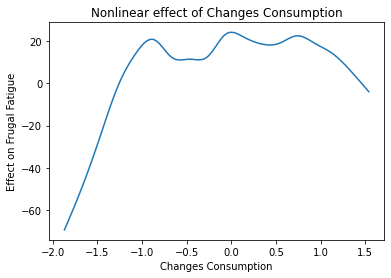

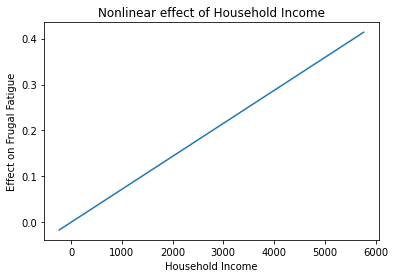

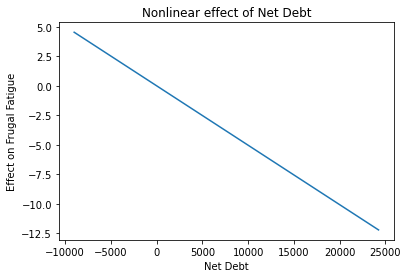

In [28]:
from pygam import LinearGAM, s, l   # s() for splines, l() for linear terms

# GAM model for the main index
gam_model = LinearGAM(s(0) + s(1) + s(2) + l(3) + l(4))
gam_model.fit(X_fatigue_train.drop(columns=['const']), y_fatigue_train)  # Remove constant from statsmodels

# Visualization of partial effects
plt.figure(figsize=(12, 8))
titles = ['Changes Expense', 'Job Search', 'Changes Consumption', 'Household Income', 'Net Debt']

for i, term in enumerate(gam_model.terms):
    if term.isintercept:
        continue
    
    XX = gam_model.generate_X_grid(term=i)
    plt.plot(XX[:, i], gam_model.partial_dependence(term=i, X=XX))
    plt.title(f'Nonlinear effect of {titles[i]}')
    plt.xlabel(titles[i])
    plt.ylabel('Effect on Frugal Fatigue')
    plt.show()

# 5.3. IV3SLS
## 5.3.1 FIRST VERSION

### Considerations on the Proposed IV3SLS Model

#### A) Structure of Equations:

* Each composite index (changes_expense, job_search, changes_consumption) is modelled as a function of its component         variables and the exogenous variables.

* The target variable (frugal_fatigue) is modelled as a function of the composite indices, which are treated as
    endogenous and instrumentalised with all exogenous and component variables.

#### B) Instrumentalisation:

* In the frugal_fatigue equation, the composite indices are treated as endogenous (enclosed in brackets).

* All component and exogenous variables are used as instruments for these indices.

#### C) Prediction Function:

* The predict_with_iv3sls() function allows the application of the estimated model to new data.

* It sequentially predicts the composite indices and then the target variable.

* It includes the classification of fatigue levels using your original function.

#### D) Model Evaluation:

* A function is included to evaluate the model on test data.

* It calculates common metrics such as MSE, RMSE, MAE, and R².

#### This approach adequately captures the hierarchical structure of the model, where the sub-indices are first calculated and then used to predict frugal fatigue, considering the potential interdependencies between the variables.

In [29]:
from linearmodels.system import IV3SLS
import pandas as pd
import numpy as np
import statsmodels.api as sm

In [30]:
 formulas = {
    'changes_expense': 'changes_expense ~ 1 + discretionary_expenses + basic_expenses + frec_offers + household_income + net_debt',
    
    'job_search': 'job_search ~ 1 + jobs_wanted + lost_expectation + jobs_lower_status + household_income + net_debt',
    
    'changes_consumption': 'changes_consumption ~ 1 + change_brands + deferred_purchases + change_preferences + household_income + net_debt',
    
    # Composite indices are treated as endogenous and instrumentalized with the exogenous variables
    'frugal_fatigue': 'frugal_fatigue ~ 1 + [changes_expense + job_search + changes_consumption ~ discretionary_expenses + basic_expenses + frec_offers + jobs_wanted + lost_expectation + jobs_lower_status + change_brands + deferred_purchases + change_preferences + household_income + net_debt]'
}

In [31]:
# Create and adjust the model
model = IV3SLS.from_formula(formulas, data=data)
results = model.fit(cov_type='robust')

print(results.summary)

# Function to save the results to a file
def save_results_to_file(results, filename='iv3sls_results.txt'):
    with open(filename, 'w') as f:
        f.write(str(results.summary))
    print(f"Results saved in {filename}")

# Save results
save_results_to_file(results)

                           System GLS Estimation Summary                           
Estimator:                        GLS   Overall R-squared:                  -12.270
No. Equations.:                     4   McElroy's R-squared:                       
No. Observations:                1000   Judge's (OLS) R-squared:            -12.270
Date:                Sat, Mar 08 2025   Berndt's R-squared:                  1.0000
Time:                        17:44:07   Dhrymes's R-squared:                -12.270
                                        Cov. Estimator:                      robust
                                        Num. Constraints:                      None
              Equation: changes_expense, Dependent Variable: changes_expense              
                        Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------------------
Intercept              -3.668e-12  2.499e-13    -14.676

C:\Users\Oscar Murgueytio\AppData\Local\Programs\Python\Python310\lib\site-packages\linearmodels\system\_utility.py:198: RuntimeWarning: invalid value encountered in sqrt
  vecs = 1.0 / np.sqrt(vecs)


In [32]:
# Function to predict using the IV3SLS model
def predict_with_iv3sls(new_data, results):
    """
    Make predictions using the estimated IV3SLS model

    Args:
    new_data: DataFrame with the new consumer data
    results: Results of the IV3SLS model

    Returns:
    DataFrame with predictions and fatigue levels
    """
    # Create copy to store results
    predictions = new_data.copy()
    
    # Extract coefficients from each equation
    coefs_expense = results.params['changes_expense']
    coefs_job = results.params['job_search']
    coefs_consumption = results.params['changes_consumption']
    coefs_fatigue = results.params['frugal_fatigue']
    
    # Predict changes_expense
    X_expense = sm.add_constant(new_data[['discretionary_expenses', 'basic_expenses', 'frec_offers', 
                                         'household_income', 'net_debt']])
    predictions['changes_expense'] = X_expense @ coefs_expense
    
    # Predict job_search
    X_job = sm.add_constant(new_data[['jobs_wanted', 'lost_expectation', 'jobs_lower_status', 
                                     'household_income', 'net_debt']])
    predictions['job_search'] = X_job @ coefs_job
    
    # Predict changes_consumption
    X_consumption = sm.add_constant(new_data[['change_brands', 'deferred_purchases', 'change_preferences', 
                                            'household_income', 'net_debt']])
    predictions['changes_consumption'] = X_consumption @ coefs_consumption
    
    # Predict frugal_fatigue using the predicted values
    X_fatigue = sm.add_constant(predictions[['changes_expense', 'job_search', 'changes_consumption']])
    predictions['pred_fatigue'] = X_fatigue @ coefs_fatigue
    
    # Classify fatigue levels using your classify_fatigue function
    predictions['fatigue_levels'] = [classify_fatigue(valor) for valor in predictions['pred_fatigue']]
    
    return predictions

In [ ]:
# Example of use with new data and with new_consumers already defined
predicted_results = predict_with_iv3sls(new_consumers, results)

print("\nPredicciones para nuevos consumidores:")
print(predicted_results[['pred_fatigue', 'fatigue_levels']].head())

In [33]:
# Function to evaluate model quality on test data
def evaluate_model(test_data, results):
    """
    Evaluate the model on test data

    Args:
    test_data: DataFrame with test data
    results: Results of the IV3SLS model

    Returns:
    DataFrame with evaluation metrics
    """
    # Making predictions on test data
    predictions = predict_with_iv3sls(test_data, results)
    
    # Calculate error metrics
    from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
    
    mse = mean_squared_error(test_data['frugal_fatigue'], predictions['pred_fatigue'])
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(test_data['frugal_fatigue'], predictions['pred_fatigue'])
    r2 = r2_score(test_data['frugal_fatigue'], predictions['pred_fatigue'])
    
    print("\nEvaluation Metrics:")
    print(f"MSE: {mse:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"R²: {r2:.4f}")
    
    return predictions

## 5.3.2. SECOND VERSION

In [34]:
from linearmodels.system import IV3SLS
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [35]:
if data.isnull().sum().sum() > 0:
    raise ValueError("The dataset contains null values, please check before continuing.")

In [36]:
# Define equations for the system

formulas = {
    'changes_expense': 'changes_expense ~ 1 + discretionary_expenses + basic_expenses + frec_offers + household_income + net_debt',
    'job_search': 'job_search ~ 1 + jobs_wanted + lost_expectation + jobs_lower_status + household_income + net_debt',
    'changes_consumption': 'changes_consumption ~ 1 + change_brands + deferred_purchases + change_preferences + household_income + net_debt',
    'frugal_fatigue': 'frugal_fatigue ~ 1 + [changes_expense + job_search + changes_consumption ~ '
                      'discretionary_expenses + basic_expenses + frec_offers + jobs_wanted + '
                      'lost_expectation + jobs_lower_status + change_brands + deferred_purchases + '
                      'change_preferences + household_income + net_debt]'
}

In [37]:
# Create and adjust the model
model = IV3SLS.from_formula(formulas, data=data)
results = model.fit(cov_type='robust')

print(results.summary)

                           System GLS Estimation Summary                           
Estimator:                        GLS   Overall R-squared:                  -12.270
No. Equations.:                     4   McElroy's R-squared:                       
No. Observations:                1000   Judge's (OLS) R-squared:            -12.270
Date:                Sat, Mar 08 2025   Berndt's R-squared:                  1.0000
Time:                        17:44:23   Dhrymes's R-squared:                -12.270
                                        Cov. Estimator:                      robust
                                        Num. Constraints:                      None
              Equation: changes_expense, Dependent Variable: changes_expense              
                        Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------------------
Intercept              -3.668e-12  2.499e-13    -14.676

C:\Users\Oscar Murgueytio\AppData\Local\Programs\Python\Python310\lib\site-packages\linearmodels\system\_utility.py:198: RuntimeWarning: invalid value encountered in sqrt
  vecs = 1.0 / np.sqrt(vecs)


In [38]:
# Save results
def save_results_to_file(results, filename='iv3sls_results.txt'):
    with open(filename, 'w') as f:
        f.write(str(results.summary))
    print(f"Results saved in  {filename}")

save_results_to_file(results)

Results saved in  iv3sls_results.txt


In [39]:
# Function to predict using the IV3SLS model
def predict_with_iv3sls(new_data, results):
    """
    Make predictions using the estimated IV3SLS model

    Args:
    new_data: DataFrame with the new consumer data
    results: Results of the IV3SLS model

    Returns:
    DataFrame with predictions and fatigue levels
    """
    predictions = new_data.copy()
    
    # Extract coefficients correctly using `LOC`
    coefs_expense = results.params.loc['changes_expense']
    coefs_job = results.params.loc['job_search']
    coefs_consumption = results.params.loc['changes_consumption']
    coefs_fatigue = results.params.loc['frugal_fatigue']

    # Ensure that matrices include a constant
    X_expense = sm.add_constant(new_data[['discretionary_expenses', 'basic_expenses', 'frec_offers', 'household_income', 'net_debt']], has_constant='add')
    predictions['changes_expense'] = X_expense @ coefs_expense

    X_job = sm.add_constant(new_data[['jobs_wanted', 'lost_expectation', 'jobs_lower_status', 'household_income', 'net_debt']], has_constant='add')
    predictions['job_search'] = X_job @ coefs_job

    X_consumption = sm.add_constant(new_data[['change_brands', 'deferred_purchases', 'change_preferences', 'household_income', 'net_debt']], has_constant='add')
    predictions['changes_consumption'] = X_consumption @ coefs_consumption

    # Predict frugal_fatigue
    X_fatigue = sm.add_constant(predictions[['changes_expense', 'job_search', 'changes_consumption']], has_constant='add')
    predictions['pred_fatigue'] = X_fatigue @ coefs_fatigue

    # Classify fatigue levels using the `classify_fatigue` function
    predictions['fatigue_levels'] = predictions['pred_fatigue'].apply(classify_fatigue)

    return predictions

In [ ]:
# Example of use with new data
predicted_results = predict_with_iv3sls(new_consumers, results)

print("\nPredictions for new consumers:")
print(predicted_results[['pred_fatigue', 'fatigue_levels']].head())

In [40]:
# Function to evaluate model quality on test data
def evaluate_model(test_data, results):
    """
    Evaluate the model on test data.

    Args:
    test_data: DataFrame with test data.
    results: Results of the IV3SLS model.

    Returns:
    DataFrame with evaluation metrics.
    """
    predictions = predict_with_iv3sls(test_data, results)

    mse = mean_squared_error(test_data['frugal_fatigue'], predictions['pred_fatigue'])
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(test_data['frugal_fatigue'], predictions['pred_fatigue'])
    r2 = r2_score(test_data['frugal_fatigue'], predictions['pred_fatigue'])

    print("\nMétricas de evaluación:")
    print(f"MSE: {mse:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"R²: {r2:.4f}")

    return predictions

#predicted_test = evaluate_model(test_data, results)

# 6. HYBRIDIZATION INDEX FRUGAL FATIGUE

In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.inspection import partial_dependence, PartialDependenceDisplay
from sklearn.cluster import KMeans
from sklearn.tree import DecisionTreeRegressor, plot_tree
from statsmodels.nonparametric.smoothers_lowess import lowess
from pygam import LinearGAM, s, l, f

## 6.1. Non-Parametric Exploratory Phase

In [42]:
# Visualizing non-linear relationships with LOWESS
plt.figure(figsize=(15, 10))

variables = ['changes_expense', 'job_search', 'changes_consumption', 'household_income', 'net_debt']

for i, var in enumerate(variables):
    plt.subplot(2, 3, i+1)
    sns.scatterplot(x=var, y='frugal_fatigue', data=data, alpha=0.4)
    
    # LOWESS adjustment for each variable
    lowess_result = lowess(data['frugal_fatigue'], data[var], frac=0.3)
    plt.plot(lowess_result[:, 0], lowess_result[:, 1], 'r-', linewidth=2)
    
    plt.title(f'Relation {var} and fatigue')
    plt.tight_layout()

plt.savefig('Nonlinear Relationship.png')
plt.close()

In [43]:
# Identify thresholds using simple decision trees to find inflection points
dt = DecisionTreeRegressor(max_depth=3, min_samples_leaf=50)
dt.fit(data[variables], data['frugal_fatigue'])

plt.figure(figsize=(20, 10))
plot_tree(dt, feature_names=variables, filled=True, rounded=True, fontsize=10)
plt.savefig('Tree Thresholds.png')
plt.close()

# Extracting thresholds from trees
def extract_thresholds(tree, feature_names):
    thresholds = {name: [] for name in feature_names}
    
    def extract_recursive(node_id=0):
        if tree.children_left[node_id] != -1:  # No es una hoja
            feature = feature_names[tree.feature[node_id]]
            threshold = tree.threshold[node_id]
            thresholds[feature].append(threshold)
            
            extract_recursive(tree.children_left[node_id])
            extract_recursive(tree.children_right[node_id])
    
    extract_recursive()
    return {k: sorted(set(v)) for k, v in thresholds.items() if v}

umbrales = extract_thresholds(dt.tree_, variables)
print("Thresholds identified in key variables:")
for var, thresholds in umbrales.items():
    print(f"{var}: {thresholds}")

Thresholds identified in key variables:
changes_expense: [-424.35096740722656, -313.2394714355469, -176.1810760498047, -62.19100761413574, 52.012943267822266, 119.66917037963867, 324.9263000488281]


In [44]:
# Segmentation by clustering for different fatigue profiles with normalized variables
X_cluster = data[variables].copy()
scaler = StandardScaler()
X_cluster_scaled = scaler.fit_transform(X_cluster)

# Finding the optimal number of clusters using the 'Elbow Method'
inertias = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_cluster_scaled)
    inertias.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), inertias, 'bx-')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method for determining optimal k')
plt.savefig('K-Means Elbow Method.png')
plt.close()

# Apply K-Means with k=3 (or the optimum according to the graph)
n_clusters = 3
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
data['cluster'] = kmeans.fit_predict(X_cluster_scaled)

# Characterize each cluster
cluster_stats = data.groupby('cluster')[variables + ['frugal_fatigue']].mean()
print("\nCustomer profiles by cluster:")
print(cluster_stats)

# Visualize the distribution of frugal fatigue by cluster
plt.figure(figsize=(12, 6))
for i in range(n_clusters):
    sns.kdeplot(data[data['cluster'] == i]['frugal_fatigue'], 
                label=f'Cluster {i}')
plt.xlabel('Frugal Fatigue Index')
plt.ylabel('Density')
plt.title('Distribution of Frugal Fatigue by Cluster')
plt.legend()
plt.savefig('Distribution Fatigue Clusters.png')
plt.close()


Customer profiles by cluster:
         changes_expense  job_search  changes_consumption  household_income  \
cluster                                                                       
0              72.201490    0.590795             0.349126       2114.577001   
1            -255.497884   -1.965127            -0.587559       3765.600619   
2             -31.989471   -0.714941            -0.171791       2988.538617   

             net_debt  frugal_fatigue  
cluster                                
0        13399.432245       33.559675  
1         6157.953071     -101.205803  
2        10372.817234      -14.610385  


## 6.2. Improved Modeling Phase

In [45]:
# Prepare variables to include identified nonlinearities
X_train = train[variables].copy()
X_test = test[variables].copy()
y_train = train['frugal_fatigue']
y_test = test['frugal_fatigue']

In [46]:
# Create polynomial terms to capture specific nonlinearities
# Based on the identified thresholds, we add quadratic terms
poly = PolynomialFeatures(degree=2, include_bias=False, interaction_only=False)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

poly_feature_names = poly.get_feature_names_out(X_train.columns)

In [47]:
# GAM model for identified nonlinear components
# s() for splines, l() for linear terms
gam_model = LinearGAM(s(0, n_splines=8) +  # changes_expense (spline)
                      s(1, n_splines=8) +  # job_search (spline)
                      s(2, n_splines=8) +  # changes_consumption (spline)
                      s(3, n_splines=10) + # household_income (spline)
                      s(4, n_splines=10))  # net_debt (spline)

gam_model.fit(X_train, y_train)
gam_pred_train = gam_model.predict(X_train)
gam_pred_test = gam_model.predict(X_test)

print("\nGAM Model Summary")
print(f"R² in training: {r2_score(y_train, gam_pred_train):.4f}")
print(f"R² in test: {r2_score(y_test, gam_pred_test):.4f}")
print(f"MSE in test: {mean_squared_error(y_test, gam_pred_test):.4f}")

# Visualize partial effects of GAM
plt.figure(figsize=(15, 12))
for i, term in enumerate(gam_model.terms):
    if term.isintercept:
        continue
    
    plt.subplot(2, 3, i+1)
    XX = gam_model.generate_X_grid(term=i)
    plt.plot(XX[:, i], gam_model.partial_dependence(term=i, X=XX))
    plt.title(f'Partial Effect: {variables[i]}')
    plt.xlabel(variables[i])
    plt.ylabel('Effect on Frugal Fatigue')

plt.tight_layout()
plt.savefig('Partial Effects GAM.png')
plt.close()


GAM Model Summary
R² in training: 0.7860
R² in test: 0.7695
MSE in test: 2306.1964


In [48]:
# Apply scikit-learn for interpretable parametric model incorporating GAM features
X_train_enhanced = pd.DataFrame(X_train).copy()
X_test_enhanced = pd.DataFrame(X_test).copy()

# For each variable, add terms for the identified inflection points
for var in umbrales:
    idx = variables.index(var)
    for threshold in umbrales[var]:
        # Binary variables for each threshold
        X_train_enhanced[f"{var}_major_{threshold:.0f}"] = (X_train_enhanced[var] > threshold).astype(int)
        X_test_enhanced[f"{var}_major_{threshold:.0f}"] = (X_test_enhanced[var] > threshold).astype(int)
        
        # Interaction with other key variables
        for other_var in variables:
            if other_var != var:
                X_train_enhanced[f"{var}_major_{threshold:.0f}_{other_var}"] = X_train_enhanced[f"{var}_major_{threshold:.0f}"] * X_train_enhanced[other_var]
                X_test_enhanced[f"{var}_major_{threshold:.0f}_{other_var}"] = X_test_enhanced[f"{var}_major_{threshold:.0f}"] * X_test_enhanced[other_var]

# Add cluster as categorical variable
X_train_enhanced['cluster'] = train['cluster'] if 'cluster' in train.columns else kmeans.predict(scaler.transform(X_train))
X_test_enhanced['cluster'] = test['cluster'] if 'cluster' in test.columns else kmeans.predict(scaler.transform(X_test))

# Adding cluster interactions with main variables
for i in range(n_clusters):
    for var in variables:
        X_train_enhanced[f'cluster_{i}_{var}'] = (X_train_enhanced['cluster'] == i).astype(int) * X_train_enhanced[var]
        X_test_enhanced[f'cluster_{i}_{var}'] = (X_test_enhanced['cluster'] == i).astype(int) * X_test_enhanced[var]

In [49]:
# Compare models
# Linear Model. Ordinary Least Squares (OLS)
X_train_sm = sm.add_constant(X_train_enhanced)
X_test_sm = sm.add_constant(X_test_enhanced)
linear_model = sm.OLS(y_train, X_train_sm).fit()

# Selection of significant variables
pvalues = linear_model.pvalues
significant_features = pvalues[pvalues < 0.05].index
print(f"\nSignificant variables ({len(significant_features)}):")
print(significant_features.tolist())

# OLS model with significant variables
X_train_sig = sm.add_constant(X_train_enhanced[significant_features.drop('const')])
X_test_sig = sm.add_constant(X_test_enhanced[significant_features.drop('const')])
final_model = sm.OLS(y_train, X_train_sig).fit()

# Evaluate the final model
pred_train = final_model.predict(X_train_sig)
pred_test = final_model.predict(X_test_sig)

print("\nSummary of the final parametric model:")
print(f"R² in training: {r2_score(y_train, pred_train):.4f}")
print(f"R² in test: {r2_score(y_test, pred_test):.4f}")
print(f"MSE in test: {mean_squared_error(y_test, pred_test):.4f}")

print("\nFinal Model Coefficients:")
print(final_model.summary().tables[1])

# Comparing both models: GAM versus improved OLS
print("\nModel Comparison:")
print(f"GAM - R² test: {r2_score(y_test, gam_pred_test):.4f}, MSE test: {mean_squared_error(y_test, gam_pred_test):.4f}")
print(f"OLS - R² test: {r2_score(y_test, pred_test):.4f}, MSE test: {mean_squared_error(y_test, pred_test):.4f}")


Significant variables (10):
['const', 'changes_expense', 'changes_expense_major_-313', 'changes_expense_major_-313_job_search', 'changes_expense_major_-313_household_income', 'changes_expense_major_-176_household_income', 'changes_expense_major_52', 'changes_expense_major_120_net_debt', 'cluster_0_changes_expense', 'cluster_2_changes_expense']

Summary of the final parametric model:
R² in training: 0.7831
R² in test: 0.7688
MSE in test: 2313.0104

Final Model Coefficients:
                                                  coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------
const                                         -35.2428     11.388     -3.095      0.002     -57.602     -12.883
changes_expense                                 0.3157      0.026     12.098      0.000       0.264       0.367
changes_expense_major_-313                     34.0812     12.859      2.

## 6.3. Improved Alert System

In [50]:
percentiles = [70, 90]  
percentile_thresholds = np.percentile(pred_train, percentiles)

def classify_fatigue_percentile(fatigue_value, thresholds):
    if fatigue_value > thresholds[1]:
        return "HIGH"
    elif fatigue_value > thresholds[0]:
        return "MEAN"
    else:
        return "LOW"

In [51]:
# Complementary risk analysis
dt_risk = DecisionTreeRegressor(max_depth=5, min_samples_leaf=30)
dt_risk.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=5, min_samples_leaf=30)

In [52]:
# Function to predict risk
def predict_risk_detailed(new_data, gam_model, linear_model, dt_risk, 
                             scaler, kmeans, poly, variables, percentile_thresholds):
    """
    Predicts the frugal fatigue level where the

    Parameter: 
    new_data: DataFrame with all the necessary variables

    Return:
    the DataFrame with predictions, risk levels and contributing factors
    """
    # Prepare data
    X_new = new_data[variables].copy()
    
    # Base predictions with the tree (for explanations)
    pred_tree = dt_risk.predict(X_new)
    
    # Assign cluster
    clusters = kmeans.predict(scaler.transform(X_new))
    
    # Improve data with transformations applied to the final model
    X_new_enhanced = pd.DataFrame(X_new).copy()
    X_new_enhanced['cluster'] = clusters
    
    # Add terms based on thresholds
    for var in umbrales:
        for threshold in umbrales[var]:
            X_new_enhanced[f"{var}_mayor_{threshold:.0f}"] = (X_new_enhanced[var] > threshold).astype(int)
            
            for other_var in variables:
                if other_var != var:
                    X_new_enhanced[f"{var}_mayor_{threshold:.0f}_{other_var}"] = X_new_enhanced[f"{var}_mayor_{threshold:.0f}"] * X_new_enhanced[other_var]
    
    # Adding cluster interactions
    for i in range(n_clusters):
        for var in variables:
            X_new_enhanced[f'cluster_{i}_{var}'] = (X_new_enhanced['cluster'] == i).astype(int) * X_new_enhanced[var]
    
    # Select significant variables
    X_new_sign = sm.add_constant(X_new_enhanced[significant_features.drop('const')])
    
    # Linear prediction
    pred_linear = final_model.predict(X_new_sign)
    
    # GAM Prediction
    pred_gam = gam_model.predict(X_nuevos)
    
    # Averaging predictions (simple ensemble)
    pred_final = (pred_linear + pred_gam) / 2
    
    # Classify the level
    levels = [classify_fatigue_percentile(valor, percentile_thresholds) for valor in pred_final]
    
    # Identify the main factors (using model coefficients)
    main_factors = []
    for i, row in X_new_enhanced.iterrows():
        # Calculate contribution of each variable
        contribution = {}
        for var in variables:
            contribution = final_model.params.get(var, 0) * row.get(var, 0)
            contributions[var] = contribution
            
            # Adding contributions from derived terms
            for col in X_new_sign.columns:
                if var in col and col != var:
                    contribution += final_model.params.get(col, 0) * row.get(col, 0)
                    contributions[var] = contribution
        
        # Sort by importance
        sorted_contrib = sorted(contributions.items(), key=lambda x: abs(x[1]), reverse=True)
        factors = [f"{k} ({v:.2f})" for k, v in sorted_contrib[:3]]
        main_factors.append(", ".join(factors))
    
    # Create the results dataframe
    results = new_data.copy()
    results['fatiga_pred'] = pred_final
    results['nivel_fatiga'] = levels
    results['main_factors'] = main_factors
    results['cluster'] = clusters
    
    return results

In [53]:
# Example of use with new simulated data
new_consumers = pd.DataFrame({
    'household_income': np.random.normal(3000, 1000, 5),
    'net_debt': np.random.normal(10000, 5000, 5),
    'changes_expense': np.random.normal(0, 200, 5),
    'job_search': np.random.normal(0, 1, 5),
    'changes_consumption': np.random.normal(0, 1, 5),
})

In [ ]:
detailed_predictions = predict_risk_detailed(new_data,
                                              gam_model,
                                              linear_model,
                                              dt_risk,
                                              scaler,
                                              kmeans,
                                              poly,
                                              variables,
                                              percentile_thresholds)

In [ ]:
print("\nDetailed predictions for new consumers:")
print(detailed_predictions[['household_income', 'net_debt', 'fatiga_pred', 
                             'nivel_fatiga', 'cluster', 'main_factors']])

## 6.4. Visualization of Results for Interpretation

In [55]:
# Scatter plot with predictions colored by risk level
plt.figure(figsize=(12, 8))
scatter = plt.scatter(test['household_income'], test['net_debt'], 
                     c=pred_test, cmap='RdYlGn_r', alpha=0.7)
plt.colorbar(scatter, label='Frugal Fatigue Index')
plt.xlabel('Household Income')
plt.ylabel('Net Debt')
plt.title('Frugal Fatigue Risk Map')
plt.savefig('Frugal Fatigue Risk Map.png')
plt.close()

In [56]:
# Heatmap of correlation between original and transformed variables
variables_importantes = list(significant_features.drop('const'))[:2]  # First 2 variables
corr_matrix = X_train_enhanced[variables_importantes].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation between Important Variables')
plt.tight_layout()
plt.savefig('Correlation Variables.png')
plt.close()

print("\nHybrid Model for Completed Frugal Fatigue Index.")


Hybrid Model for Completed Frugal Fatigue Index.


# 7. ADVANCED VISUALIZATIONS FOR THE FRUGAL FATIGUE MODEL

In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.gridspec as gridspec
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.inspection import permutation_importance
import shap
from lime import lime_tabular

## 7.1. Relationships Between Variables

In [58]:
def exploratory_visualizations(data, variables, save_path=None):
    """
    Create exploratory visualizations to better understand the relationships between the variables of the frugal fatigue model.
    """

    main_variables = variables + ['frugal_fatigue']
    g = sns.pairplot(data[main_variables], 
                    diag_kind="kde", 
                    plot_kws={'alpha': 0.6, 's': 30, 'edgecolor': 'k'},
                    height=2.5)
    g.fig.suptitle('Relationships between Variables and Frugal Fatigue', y=1.02, fontsize=16)
    if save_path:
        plt.savefig(f"{save_path}/pairplot_variables.png", bbox_inches='tight')
    plt.close()

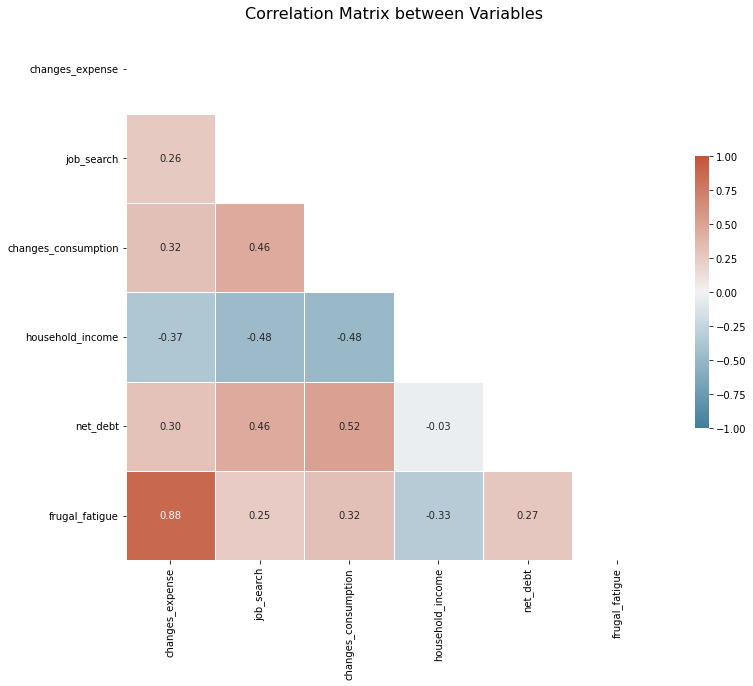

In [59]:
main_variables = variables + ['frugal_fatigue'] 

plt.figure(figsize=(12, 10))
mask = np.triu(np.ones_like(data[main_variables].corr(), dtype=bool))
custom_cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(data[main_variables].corr(), 
           mask=mask, 
           cmap=custom_cmap, 
           vmax=1, 
           vmin=-1, 
           center=0,
           square=True, 
           linewidths=.5, 
           cbar_kws={"shrink": .5}, 
           annot=True, 
           fmt='.2f')
plt.title('Correlation Matrix between Variables', fontsize=16)

plt.show()



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



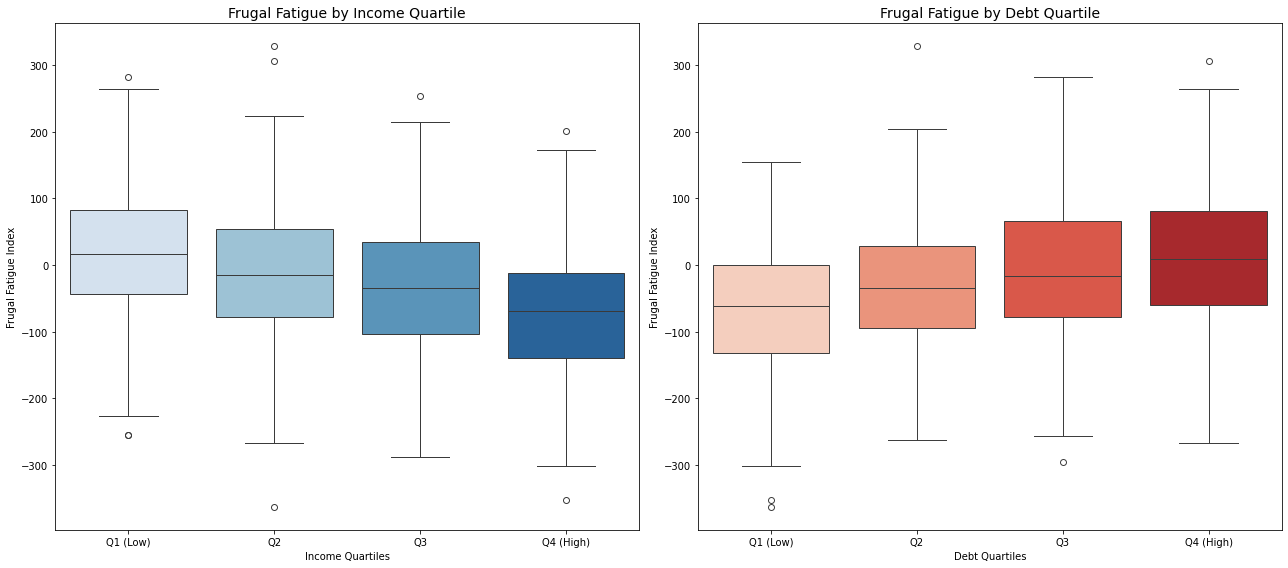

In [60]:
# Boxplots of frugal fatigue by income and debt quartiles
fig, axes = plt.subplots(1, 2, figsize=(18, 8))

# Income quartiles
data['income_quartiles'] = pd.qcut(data['household_income'], 4, labels=['Q1 (Low)', 'Q2', 'Q3', 'Q4 (High)'])
sns.boxplot(x='income_quartiles', y='frugal_fatigue', data=data, ax=axes[0], palette='Blues')
axes[0].set_title('Frugal Fatigue by Income Quartile', fontsize=14)
axes[0].set_xlabel('Income Quartiles')  
axes[0].set_ylabel('Frugal Fatigue Index')

# Debt Quartiles
data['debt_quartiles'] = pd.qcut(data['net_debt'], 4, labels=['Q1 (Low)', 'Q2', 'Q3', 'Q4 (High)'])
sns.boxplot(x='debt_quartiles', y='frugal_fatigue', data=data, ax=axes[1], palette='Reds')
axes[1].set_title('Frugal Fatigue by Debt Quartile', fontsize=14)
axes[1].set_xlabel('Debt Quartiles')
axes[1].set_ylabel('Frugal Fatigue Index')
    
plt.tight_layout()

plt.show()

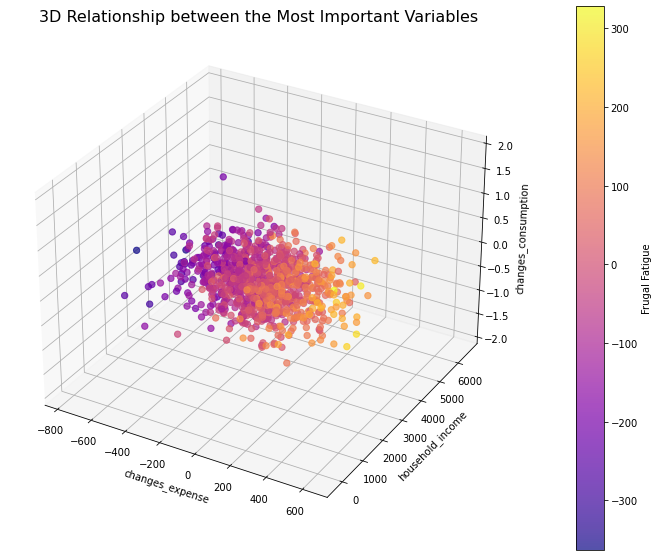

In [61]:
# 3D visualization of the 3 most important variables
correlations = data[variables].corrwith(data['frugal_fatigue']).abs().sort_values(ascending=False)
top3_vars = correlations.index[:3].tolist()
    
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')
    
scatter = ax.scatter(data[top3_vars[0]], 
                    data[top3_vars[1]], 
                    data[top3_vars[2]],
                    c=data['frugal_fatigue'], 
                    cmap='plasma', 
                    s=40, 
                    alpha=0.7)
    
ax.set_xlabel(top3_vars[0])
ax.set_ylabel(top3_vars[1])
ax.set_zlabel(top3_vars[2])
plt.colorbar(scatter, label='Frugal Fatigue', pad=0.1)
plt.title(f'3D Relationship between the Most Important Variables', fontsize=16)
    
plt.show()

## 7.2. Interpretation of the Model

In [62]:
def visualizations_interpretation(model, X_train, X_test, y_train, y_test, variables, save_path=None):
    """
    Visualizations that help interpret the frugal fatigue model.
    """
    # Standardized coefficients
    if hasattr(model, 'params'):
        # Statsmodels Model
        coefs = model.params[1:] # Exclude constant
        std_coefs = coefs * X_train.std()[coefs.index]
        importances = pd.Series(std_coefs.abs(), index=coefs.index).sort_values(ascending=False)
        
        plt.figure(figsize=(12, 8))
        importances.head(15).plot(kind='barh', color='skyblue')
        plt.title('Importance of Variables (Standardized Coefficients)', fontsize=16)
        plt.xlabel('Importance')
        plt.tight_layout()
        if save_path:
            plt.savefig(f"{save_path}/Importance Variables.png", bbox_inches='tight')
        plt.close()
    else:
        # Scikit-learn Model with feature importances
        if hasattr(model, 'feature_importances_'):
            importances = pd.Series(model.feature_importances_, index=variables).sort_values(ascending=False)
            
            plt.figure(figsize=(12, 8))
            importances.plot(kind='barh', color='skyblue')
            plt.title('Importance Variables', fontsize=16)
            plt.xlabel('Importance')
            plt.tight_layout()
            if save_path:
                plt.savefig(f"{save_path}/Importance Variables.png", bbox_inches='tight')
            plt.close()
        else:
        # Permutation 
            result = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42)
            importances = pd.Series(result.importances_mean, index=variables).sort_values(ascending=False)
            
            plt.figure(figsize=(12, 8))
            importances.plot(kind='barh', color='skyblue')
            plt.title('Importance of Variables (Permutation Importance)', fontsize=16)
            plt.xlabel('Importance')
            plt.tight_layout()
            if save_path:
                plt.savefig(f"{save_path}/Importance Variables.png", bbox_inches='tight')
            plt.close()
    
    # Model Residuals
    if hasattr(model, 'predict'):
        y_pred = model.predict(X_test)
        residuals = y_test - y_pred
        
        plt.figure(figsize=(12, 8))
        plt.scatter(y_pred, residuals, alpha=0.5)
        plt.axhline(y=0, color='r', linestyle='-')
        plt.title('Residuals vs Predicted Values', fontsize=16)
        plt.xlabel('Predicted Values')
        plt.ylabel('Residuals')
        if save_path:
            plt.savefig(f"{save_path}/Residuals vs Predicted Values.png", bbox_inches='tight')
        plt.close()
        
        # QQ-Plot Residuals
        plt.figure(figsize=(12, 8))
        sm.qqplot(residuals, line='45', fit=True)
        plt.title('QQ-Plot Residuals', fontsize=16)
        plt.tight_layout()
        if save_path:
            plt.savefig(f"{save_path}/QQ-Plot Residuals.png", bbox_inches='tight')
        plt.close()
        
        # Histogram of Residuals
        plt.figure(figsize=(12, 8))
        sns.histplot(residuals, kde=True, bins=30)
        plt.axvline(x=0, color='r', linestyle='--')
        plt.title('Residuals Distribution', fontsize=16)
        plt.xlabel('Residuals')
        plt.ylabel('Frecuencia')
        if save_path:
            plt.savefig(f"{save_path}/Histogram of Residuals.png", bbox_inches='tight')
        plt.close()
    
    return importances